# Lecture 12 demo notebook for the bootstrap

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error


plt.style.use("fivethirtyeight")

## 1. Bootstrap for 1D distributions

### 1.1 Empirical CDF vs CDF

Empirical CDF is pretty close to CDF after N = 50. Recall, this is step 1 of the bootstrap approximation.

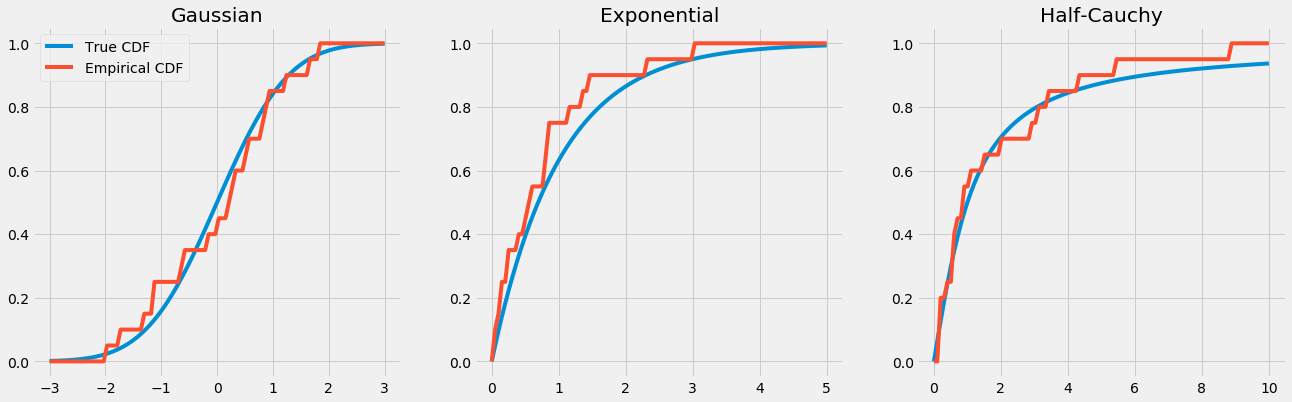

In [7]:
N = 20

fig, ax = plt.subplots(1,3, figsize = (20,6))

# Gaussian
X = np.random.normal(size=N)
empirical_cdf = ECDF(X)
xgrid = np.linspace(-3,3,100)

ax[0].plot(xgrid, stats.norm.cdf(xgrid), label="True CDF")
ax[0].plot(xgrid, empirical_cdf(xgrid), label="Empirical CDF")
ax[0].set_title("Gaussian")
ax[0].legend()

# Exponential
X = np.random.exponential(size=N)
empirical_cdf = ECDF(X)
xgrid = np.linspace(0,5,100)

ax[1].plot(xgrid, stats.expon.cdf(xgrid))
ax[1].plot(xgrid, empirical_cdf(xgrid))
ax[1].set_title("Exponential")

# Half-Cauchy
X = stats.halfcauchy.rvs(size=N)
empirical_cdf = ECDF(X)
xgrid = np.linspace(0,10,100)

ax[2].plot(xgrid, stats.halfcauchy.cdf(xgrid))
ax[2].plot(xgrid, empirical_cdf(xgrid))
ax[2].set_title("Half-Cauchy")

plt.show()

### 1.2 Bootstrap distribution of sample mean

In [8]:
def bootstrap_1d(samples, B=1000, fnc=np.mean):
    theta_boot = np.zeros(shape=(B,))
    for b in range(B):
        bootstrap_samples = rnd.choice(samples, N)
        theta_boot[b] = fnc(bootstrap_samples)
        
    return theta_boot

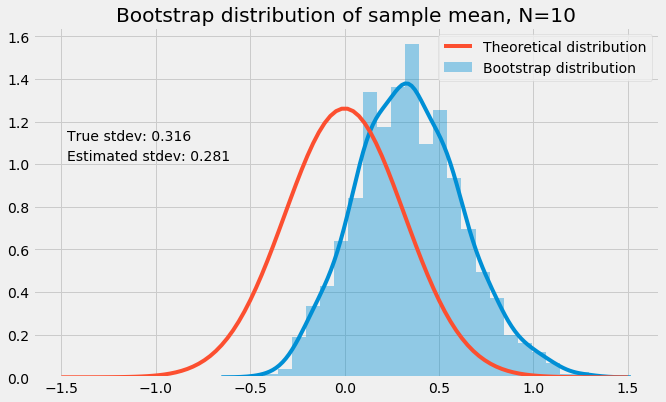

In [22]:
mu = 0.0
sigma = 1.0
N = 10
samples = rnd.normal(mu, sigma, N)

X_grid = np.linspace(-1.5,1.5,100)

mu_boot = bootstrap_1d(samples, fnc=np.mean)

plt.figure(figsize=(10,6))
sns.distplot(mu_boot, label="Bootstrap distribution")
plt.plot(X_grid, stats.norm.pdf(X_grid, loc=mu, scale=sigma/np.sqrt(N)),
         label="Theoretical distribution")
plt.title(f"Bootstrap distribution of sample mean, N={N}")
plt.annotate(f"Estimated stdev: {np.std(mu_boot):.3f}", (0.1, 0.6),
             xycoords="figure fraction")
plt.annotate(f"True stdev: {sigma / np.sqrt(N):.3f}", (0.1, 0.65),
             xycoords="figure fraction")
plt.legend()
plt.show()

#print(f'Estimated stdev: %.3f' % np.std(mu_boot))
#print(f'True stdev: %.3f' % (sigma / np.sqrt(N)))

Becomes better approximation as the sample size $N$ increases, but $N=10$ is already surprisingly good.

In [23]:
N_vals = (np.arange(10)+1) * 10
reps = 20

error_in_mean = []
error_in_sd = []
for N in N_vals:
    true_mean = np.ones(reps) * mu
    est_mean = np.zeros(reps)
    true_std = sigma / np.sqrt(N) * np.ones(reps)
    est_std = np.zeros(reps)
    for i in range(reps):
        samples = rnd.normal(mu, sigma, N)
        est_mean[i] = np.mean(samples)
        mu_boot = bootstrap_1d(samples, fnc=np.mean)
        est_std[i] = np.std(mu_boot)
    error_in_mean.append(mean_squared_error(true_mean, est_mean))
    error_in_sd.append(mean_squared_error(true_std, est_std))

In [24]:
N_vals

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

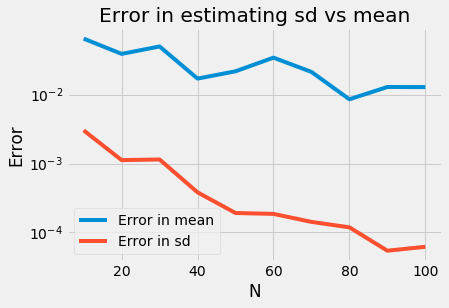

In [26]:
plt.plot(N_vals, error_in_mean, label="Error in mean")
plt.plot(N_vals, error_in_sd, label="Error in sd")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()
plt.semilogy()
plt.title("Error in estimating sd vs mean")
plt.show()

### 1.3 Bootstrap distribution of sample mean, median and 90th percentile

In [27]:
def simulate_from_true(N, mu, sigma, K=5000, fnc=np.mean):
    theta_hat = np.zeros(shape=(K,))
    for k in range(K):
        samples = rnd.normal(mu, sigma, N)
        theta_hat[k] = fnc(samples)
        
    return theta_hat

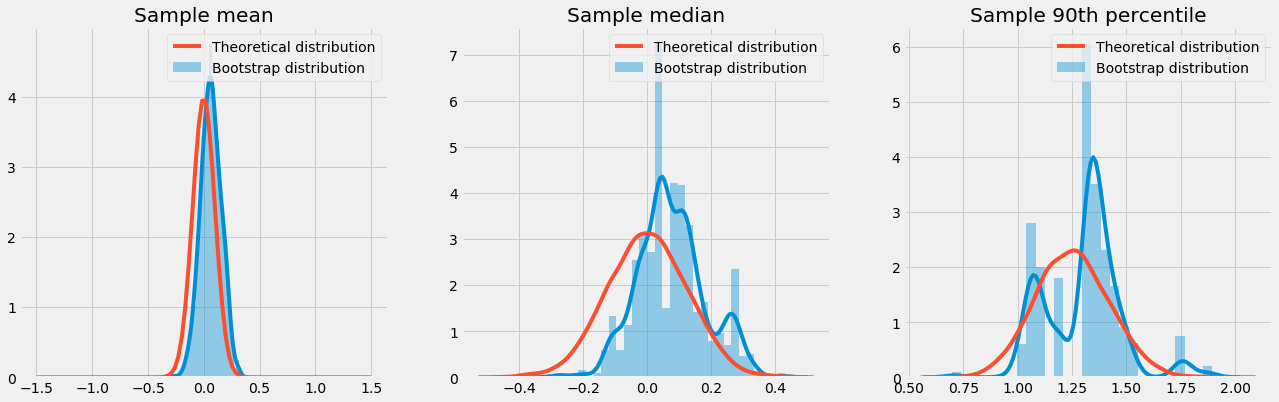

In [29]:
N = 100
samples = rnd.normal(mu, sigma, N)

fig, ax = plt.subplots(1,3, figsize = (20,6))

# Sample mean
X_grid = np.linspace(-1.5,1.5,100)
mu_boot = bootstrap_1d(samples, fnc=np.mean)
mu_hat = simulate_from_true(N, mu, sigma, fnc=np.mean)


sns.distplot(mu_boot, label="Bootstrap distribution", ax=ax[0])
ax[0].plot(X_grid, stats.norm.pdf(X_grid, loc=mu, scale=sigma/np.sqrt(N)),
         label="Theoretical distribution")
ax[0].set_title("Sample mean")
ax[0].legend()

# Sample median
X_grid = np.linspace(-1.5,1.5,100)
med_boot = bootstrap_1d(samples, fnc=np.median)
med_hat = simulate_from_true(N, mu, sigma, fnc=np.median)

sns.distplot(med_boot, label="Bootstrap distribution", ax=ax[1])
sns.distplot(med_hat, hist=False, label="Theoretical distribution", ax=ax[1])
ax[1].set_title("Sample median")

# Sample 90th percentile
X_grid = np.linspace(0,4,100)
perc90_fnc = lambda x : np.quantile(x, 0.9)
perc90_boot = bootstrap_1d(samples, fnc=perc90_fnc)
perc90_hat = simulate_from_true(N, mu, sigma, fnc=perc90_fnc)

sns.distplot(perc90_boot, label="Bootstrap distribution", ax=ax[2])
sns.distplot(perc90_hat, hist=False, label="Theoretical distribution", ax=ax[2])
ax[2].set_title("Sample 90th percentile")

plt.show()

Median and 90th percentile requires more samples in order to give good approximations.

### 1.4 Bootstrap distribution of sample max

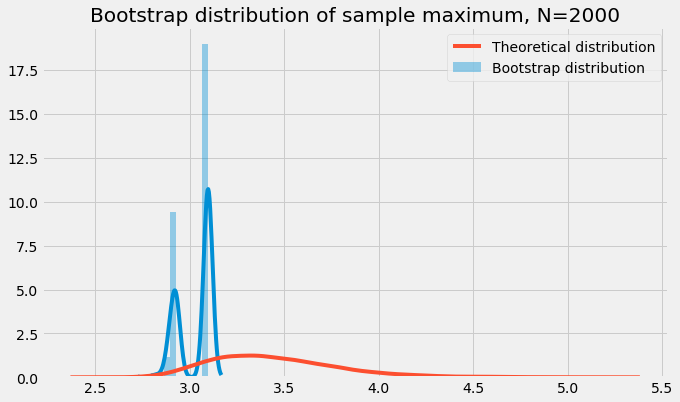

Estimated stdev: 0.092
True stdev: 0.022


In [38]:
N = 2000
samples = rnd.normal(mu, sigma, N)

max_boot = bootstrap_1d(samples, fnc=np.max)
max_hat = simulate_from_true(N, mu, sigma, fnc=np.max)

plt.figure(figsize=(10,6))
sns.distplot(max_boot, label="Bootstrap distribution")
sns.distplot(max_hat, hist=False, label="Theoretical distribution")
plt.title(f"Bootstrap distribution of sample maximum, N={N}")
plt.legend()
plt.show()

print(f'Estimated stdev: %.3f' % np.std(mu_boot))
print(f'True stdev: %.3f' % (sigma / np.sqrt(N)))

## 2. Bootstrap for GLM

In [49]:
def bootstrap_xy(X, y, fnc, w=None, B=1000, plot=True):
    d = X.shape[1]
    N = X.shape[0]
    w_hat = fnc(X, y)
    w_boot = np.zeros(shape=(B,d))
    for b in range(B):
        bootstrap_indices = rnd.choice(np.arange(N), N)
        bootstrap_X = X.iloc[bootstrap_indices, :]
        bootstrap_y = y.iloc[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    if plot:
        plt.scatter(w_boot[:,0], w_boot[:,1], c='b')
        plt.scatter(w_hat[0], w_hat[1], c='r', marker='x', s=300)
        if w:
            plt.scatter(w[0], w[1], c='g', marker='x', s=300)
        plt.show()
    return w_boot

In [50]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
turbines.head()

,t_state,t_built,t_cap,year
0,AK,6,390.0,-3.0
1,AK,6,475.0,-1.0
2,AK,2,100.0,0.0
3,AK,1,1500.0,1.0
4,AK,1,100.0,2.0


In [51]:
# Turbines in Oklahoma (where the wind comes sweepin' down the plain...)
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

In [52]:
def lin_model(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.Gaussian()
    )
    results = model.fit()
    params = results.params
    
    return params

def poisson_model(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.Poisson()
    )
    results = model.fit()
    params = results.params
    
    return params

def negbin_model(x, y): 
    model = sm.GLM(
        y, x,
        family=sm.families.NegativeBinomial()
    )
    results = model.fit()
    params = results.params
    
    return params

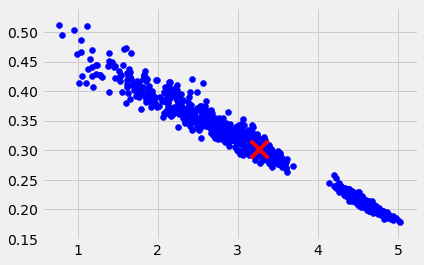

In [53]:
w_gaussian_boot = bootstrap_xy(sm.add_constant(ok_turbines.year), ok_turbines.log_totals, lin_model)

In [54]:
beta_0, beta_1 = w_gaussian_boot.std(axis = 0)
print(f"Bootstrap std error for const: {beta_0:.3f}")
print(f"Bootstrap std error for year: {beta_1:.3f}")

Bootstrap std error for const: 1.026
Bootstrap std error for year: 0.073


In [55]:
gaussian_model = sm.GLM(
    ok_turbines.log_totals, sm.add_constant(ok_turbines.year), 
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             log_totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.1810
Method:                          IRLS   Log-Likelihood:                -24.472
Date:                Thu, 25 Feb 2021   Deviance:                       17.716
Time:                        13:49:43   Pearson chi2:                     17.7
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2602      0.590      5.526      0.0

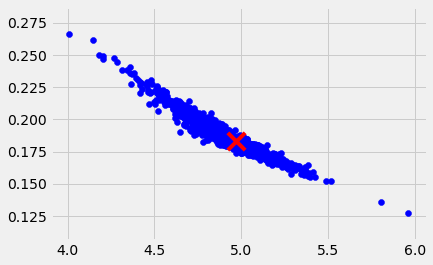

In [56]:
w_poisson_boot = bootstrap_xy(sm.add_constant(ok_turbines.year), ok_turbines.totals, poisson_model)

In [58]:
beta_0, beta_1 = w_poisson_boot.std(axis = 0)
print(f"Bootstrap std error for const: {beta_0:.3f}")
print(f"Bootstrap std error for year: {beta_1:.3f}")

Bootstrap std error for const: 0.214
Bootstrap std error for year: 0.016


In [59]:
poisson_model = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.Poisson()
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -755.42
Date:                Thu, 25 Feb 2021   Deviance:                       1366.3
Time:                        13:57:02   Pearson chi2:                 1.20e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9697      0.023    219.386      0.0

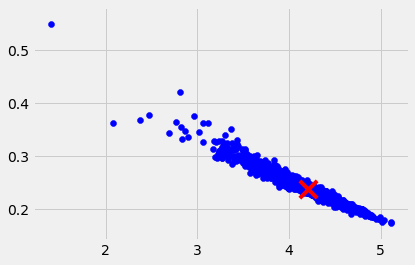

In [60]:
w_negbin_boot = bootstrap_xy(sm.add_constant(ok_turbines.year), ok_turbines.totals, negbin_model)

In [61]:
beta_0, beta_1 = w_negbin_boot.std(axis = 0)
print(f"Bootstrap std error for const: {beta_0:.3f}")
print(f"Bootstrap std error for year: {beta_1:.3f}")

Bootstrap std error for const: 0.430
Bootstrap std error for year: 0.035


In [62]:
negbin_model = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model.fit()
print(negbin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.14
Date:                Thu, 25 Feb 2021   Deviance:                       7.1483
Time:                        13:57:50   Pearson chi2:                     1.90
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2059      0.544      7.725      0.0